# MSIN0097 Individual Corsework

https://github.com/ToshaQE/Predictive-Individual

Word Count : 1042

### Installing Libraries and Dependencies

In [1]:
# To display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it."
%autosave 60

import pandas as pd
import numpy as np
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
import joblib
import pickle
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import warnings
warnings.filterwarnings("ignore")

Autosaving every 60 seconds


Stock price prediction has for a long time been a subject of many debates and exhaustive research. One concept which emerged from the literature, and which has largely dominated the debate ever since is the Efficient Market Hypothesis (EMH). EMH in its strong form states that at any point in time all information regarding a particular stock is incorporated in its current price, and it is equally likely that the price will go up or down in the immediate future, making any educated attempts at its prediction obsolete. However, empirical data shows that the strong form of EMH does not hold, and in reality, it is possible to make use of openly available fundamental and technical stock indicators to predict the likely direction of its price. This is exactly what this paper will attempt to do.

In particular, we will examine a number of machine learning algorithms to determine whether a hypothetical investor should hold, sell or buy a stock given a set of indicators available to him today. The outcome variable is determined using the following logic – if the stock’s price decreases by 1%  N days in the future, the investor should sell the stock today; if price goes up by 1%, the investor should buy more stock; if stock’s value remains somewhere in between, the investor should hold. The algorithms examined hence will attempt to solve a 3-class classification task.

Importantly, the structure and the analysis of this paper is insipid by the work of Matloob and Khushi (2021) (https://doi.org/10.3390/asi4010017). However, we significantly extend their analysis by deriving the labels 5 days further into the future, adding new models, fine-tuning them and deriving a voting classifier.

Business applications of instruments predicting stock price direction varies drastically. It can be applied by an asset fund trying to generate additional returns on its clients’ holdings or by a central banker analysing stock market’s behaviour in the immediate future to understand potential policy context. In short, any business or an institution that is involved in stock market trade might wish to employ an algorithm developed and analysed in this paper.

## Loading in and formatting the data

### Loading in the data

In [148]:
data = pd.read_csv("55_Firms_2.csv")
data.head(5)

,Date,AAPL Close,AAPL Adj. Close,AAPL P/E (LTM),AAPL EPS - Est High (NTM),AAPL EPS - Est Low (NTM),AAPL Volume,AAPL SI (%),AAPL Vol,AAPL # Buys,...,AMGN EPS - Est Low (NTM),AMGN Volume,AMGN SI (%),AMGN Vol,AMGN # Buys,AMGN # Sell,AMGN # Hold,AMGN Rating,AMGN Mkt Cap,AMGN EPS - Est Avg (NTM)
0,1/2/2003,0.264285,0.226300,82.589062,0.00714,0.00232,182317016,NaN,0.051974,1,...,1.55,14254890,NaN,0.363758,NaN,NaN,NaN,NaN,63478.08136,1.6187
1,1/3/2003,0.266071,0.227830,83.147187,0.00714,0.00232,147975184,NaN,0.052158,1,...,1.55,8311770,NaN,0.346956,NaN,NaN,NaN,NaN,63310.76282,1.6187
2,1/6/2003,0.266071,0.227830,83.147187,0.00714,0.00214,391594000,NaN,0.051699,1,...,1.55,14671690,NaN,0.352543,NaN,NaN,NaN,NaN,64700.79379,1.6187
3,1/7/2003,0.265178,0.227065,82.868125,0.00714,0.00214,346265920,NaN,0.050062,1,...,1.55,15768390,NaN,0.345180,NaN,NaN,NaN,NaN,64662.18182,1.6191
4,1/8/2003,0.259821,0.222478,81.194062,0.00714,0.00214,230100640,NaN,0.049807,1,...,1.55,12139460,NaN,0.346149,NaN,NaN,NaN,NaN,62911.77244,1.6191


We used Koyfin platform (https://koyfin.com) to download the data. The data contains stocks closing and adjusted prices, four fundamental and technical indicators, as well as analyst recommendations for 55 firms listed on top of the S&P 500 index (as of 01/03/2022) for the period from 02 Jan 2003 to 02 Dec 2019 and contains 4260 rows. 
Tickers for the first ten companies can be seen below:

In [145]:
#Making a list of unique companies
all_collumns = list(data.columns)
all_tickers = []
counter = 15

for i in all_collumns[1:]:
    if counter%14 == True:
        all_tickers.append(i.split(" ", 1)[0])
    counter += 1

len(all_tickers)
all_tickers[0:10]

55

['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'FB', 'JPM', 'UNH', 'JNJ', 'PG', 'V']

The 14 original features are below:

In [147]:
all_collumns = list(data.columns)
features = []
counter = 14

for i in all_collumns[0:15]:
    features.append(i.split(" ", 1)[1])

features[1:]

['Close',
 'Adj. Close',
 'P/E (LTM)',
 'EPS - Est High (NTM)',
 'EPS - Est Low (NTM)',
 'Volume',
 'SI (%)',
 'Vol',
 '# Buys',
 '# Sell',
 '# Hold',
 'Rating',
 'Mkt Cap',
 'EPS - Est Avg (NTM)']

The initial format of our data, however, is not well-suited for machine learning analysis as it lists companies’ data in a horizontal fashion. Hence, we create 55 separate data frames, each containing data for an individual company. Furthermore, we create some additional features such as stock price standard deviation over 5, 10 and 15 days and percentage of each recommendation type out of total number of recommendations (see below for full feature list). Finally, we create sell, hold and buy labels for 15 days in the future.

First 5 rows of an individual dataframe for Apple can be seen below:

In [149]:
#Separating the data into dataframes for each company, dealing with N/A's and creating new features;
#Having perfomred the above manipulations, we merge data into one DataFrame

dfs = []
indices = indices = list(range(0,784,14))
counter = 1

for i in indices[0:-1]:
    df = pd.DataFrame(np.nan, np.arange(4259), columns=features)
    #Setting the first column equal to date
    df.iloc[:,0]=data.iloc[:,0]

    if i != 756:
        start = i+1
        stop = indices[counter]+1
        df.iloc[:,1:15] = data.iloc[:,start:stop]
    
    else:
        start = i
        stop = 756 + 15
        df.iloc[:,1:15] = data.iloc[:,start:stop]

    # Dealing with N/A's
    
   

    # df['Total Rec'] = df['# Buys'] + df['# Sell'] + df['# Hold']

    #Total number of reccomentaions and % of each recommnedtion type (buy, sell, hold)
    df.insert(12,'Total Rec', 0)
    df.iloc[:,12] = df['# Buys'] + df['# Sell'] + df['# Hold']
    df.insert(13,'% Buy', 0)
    df.insert(14,'% Sell', 0)
    df.insert(15,'% Hold', 0)

    pc_change = 0.01

    for n in range(0,len(df.index)-15):

        total_recs = df.iloc[n]['Total Rec']

        if (total_recs != 0):
            df.at[n, '% Buy'] = df.iloc[n]['# Buys']/total_recs

            df.at[n, '% Sell'] = df.iloc[n]['# Sell']/total_recs

            df.at[n, '% Hold'] = df.iloc[n]['# Hold']/total_recs
        
        else:
            df.at[n, '% Buy'] = 0

            df.at[n, '% Sell'] = 0

            df.at[n, '% Hold'] = 0
    
       
        price_0 = df.iloc[n]['Close']      
        price_1 = df.iloc[n+1]['Close'] 
        price_2 = df.iloc[n+2]['Close'] 
        price_3 = df.iloc[n+3]['Close']
        price_4 = df.iloc[n+4]['Close'] 
        price_5 = df.iloc[n+5]['Close']
        price_6 = df.iloc[n+6]['Close'] 
        price_7 = df.iloc[n+7]['Close']
        price_8 = df.iloc[n+8]['Close'] 
        price_9 = df.iloc[n+9]['Close']
        price_10 = df.iloc[n+10]['Close']
        price_11 = df.iloc[n+11]['Close']
        price_12 = df.iloc[n+12]['Close']
        price_13 = df.iloc[n+13]['Close']
        price_14 = df.iloc[n+14]['Close']
        price_15 = df.iloc[n+15]['Close']

        price_days = [price_0, price_1, price_2, price_3, price_4, price_5, price_6, price_7, price_8,
        price_9, price_10, price_11, price_12, price_13, price_14, price_15]

        df.at[n+5,'std_5days'] = np.std(price_days[0:5], ddof=1) 
        df.at[n+5,'std_10days'] = np.std(price_days[0:10], ddof=1)
        df.at[n+15,'std_15days'] = np.std(price_days[0:15], ddof=1) 


        df.at[n+5, '% change_5d'] = (price_4-price_0)/price_0
        df.at[n+10, '% change_5d'] = (price_9-price_0)/price_0
        df.at[n+15, '% change_5d'] = (price_14-price_0)/price_0


        for j in range(0, 16):

            if j==0:
                continue

            else:
                # buy=2 sell=0 hold=1
                if((price_days[j]-price_0) >= pc_change * price_0):
                    df.at[n,'day_' + str(j)] = 2

                elif((price_days[j]-price_0) <= -(pc_change * price_0)):
                    df.at[n,'day_' + str(j)] = 0

                else:
                    df.at[n,'day_' + str(j)] = 1

    #Truncating the data for younger companies with N/A's only at the start of the 2000's  
    df.iloc[:,1:] = df.iloc[:,1:].astype(float).interpolate()
    df.dropna(thresh=35, inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.reset_index(drop=True, inplace=True)



    # df.dropna(subset=['Close'], inplace=True)

    dfs.append(df)
    counter += 1


dfs[1].head(5)

,Date,Close,Adj. Close,P/E (LTM),EPS - Est High (NTM),EPS - Est Low (NTM),Volume,SI (%),Vol,# Buys,...,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15
0,1/9/2003,27.905,17.580627,35.994469,1.08,0.900,62048642.0,0.953692,0.307837,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1/10/2003,27.960,17.615278,36.065413,1.08,0.900,67985474.0,0.953692,0.306803,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1/13/2003,28.195,17.763332,36.368538,1.08,0.900,61040600.0,0.953692,0.305531,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1/14/2003,28.485,17.946037,36.742607,1.08,0.915,54441838.0,0.953692,0.304476,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1/15/2003,28.135,17.725531,36.291144,1.08,0.915,59999384.0,0.953692,0.284455,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
#All features + labels
all_collumns = list(dfs[1].columns)
all_collumns

['Date',
 'Close',
 'Adj. Close',
 'P/E (LTM)',
 'EPS - Est High (NTM)',
 'EPS - Est Low (NTM)',
 'Volume',
 'SI (%)',
 'Vol',
 '# Buys',
 '# Sell',
 '# Hold',
 'Total Rec',
 '% Buy',
 '% Sell',
 '% Hold',
 'Rating',
 'Mkt Cap',
 'EPS - Est Avg (NTM)',
 'std_5days',
 'std_10days',
 'std_15days',
 '% change_5d',
 'day_1',
 'day_2',
 'day_3',
 'day_4',
 'day_5',
 'day_6',
 'day_7',
 'day_8',
 'day_9',
 'day_10',
 'day_11',
 'day_12',
 'day_13',
 'day_14',
 'day_15']

We then merge all dataframes to form a new long dataframe, which is much more well-suited for machine learning analysis, with total of 151,424 rows.

It is important to note that we are well aware of all caveats associated with working with time-series data, and that we do not run any root tests nor apply any related transformations for a simple reason: we are interested in the predictive capability of our features irrespective of the time.


In [152]:
data_long = pd.concat(dfs)

To ensure that the models do not pick up on any long-term trends while training we shuffle the data (and reset the index).

In [156]:
df_new = data_long.sample(frac=1).reset_index(drop=True)

## Data analysis and Visualisations
s

In [116]:
pc_sell = vis1.loc[:,'#Sell'].sum()/vis1.loc[:,'#Total'].sum()
pc_hold = vis1.loc[:,'#Hold'].sum()/vis1.loc[:,'#Total'].sum()
pc_buy = vis1.loc[:,'#Buy'].sum()/vis1.loc[:,'#Total'].sum()
print(pc_sell, pc_hold, pc_buy)

0.294879719639335 0.2762635601577909 0.4288567202028741


First, we would like to see whether an investors strategy (and the position he favors today) might change depending on the time horizon at the end of which he expects to collect his returns.  To do this we plot what would his strategy be if he knew the future price one day at a time over 15 days in the future. It appears that his strategy would change drastically depending on the time horizon – at the start of the horizon there is a 60% chance that his preferred strategy would be to hold a stock, and only around 20% that he should sell or buy it. Looking at the stock’s price on the 15th day, however, today he would prefer to buy more with a 52% chance, sell with a 32% chance and hold with a 16% chance. We hence, should expect our models to give different prediction given the day label.

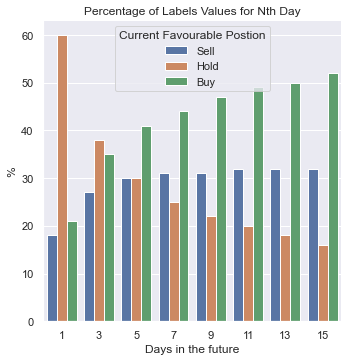

In [167]:
df = df_new

#Separating df into features and labels  
features = df.iloc[:,1:23]
labels = df.iloc[:,23:]

vis1_col = ['#Sell','#Hold', '#Buy']
days = list(labels.columns)

vis1 = pd.DataFrame(index=days, columns = vis1_col)

for i in days:
    vis1.loc[i, '#Sell'] = (df.loc[:,i] == 0).sum()
    vis1.loc[i, '#Hold'] = (df.loc[:,i] == 1).sum()
    vis1.loc[i, '#Buy'] = (df.loc[:,i] == 2).sum()
    vis1['#Total'] = vis1['#Sell'] + vis1['#Hold'] + vis1['#Buy']
    # vis1.loc[:,'#Total'] = vis1.loc[:,'#Sell'] + vis1.loc[:,'#Hold'] + vis1.loc[:, '#Buy']
    vis1.loc[:, '% Sell'] = (vis1.loc[:, '#Sell']/vis1.loc[:,'#Total'])*100
    vis1.loc[:, '% Hold'] = (vis1.loc[:, '#Hold']/vis1.loc[:,'#Total'])*100
    vis1.loc[:, '% Buy'] = (vis1.loc[:, '#Buy']/vis1.loc[:,'#Total'])*100

vis1.insert(0,'Day_n', list(range(1,16)))
vis1.reset_index(drop=True, inplace=True)
    
vis1 = vis1.astype(float).round()
vis11 = vis1.iloc[:, 5:]
vis11.rename(columns={'% Sell':'Sell','% Hold':'Hold', '% Buy':'Buy'},
inplace=True)
vis11.insert(0,'Day_n', list(range(1,16)))
vis11 = vis11.iloc[::2,:]
vis11 = pd.melt(vis11, id_vars="Day_n", var_name="Current favourable postion", value_name="%")
# vis11
sns.set_theme()

vis1_sns = sns.factorplot(data=vis11, x='Day_n', y='%', 
hue='Current favourable postion', kind='bar', legend=False)

vis1_sns.set(xlabel='Days in the future', ylabel='%')
plt.legend(loc='upper center', title='Current Favourable Postion')

vis1_sns.set(title='Percentage of Labels Values for Nth Day')


One might argue that this finding suggest that we might have to rebalance our classes. We counter this critique by saying two thigs. First, we intend to use F1 Weighted as the scoring techniques, which accounts for possible problems associated with imbalanced classes. Second, we do not wish to lose valuable information which potentially lies in the imbalanced classes. This is particularly important given that the smooth pattern of the graph above suggests that this imbalance is not random. Lastly, our test data will have the same distribution as above, meaning that it should not be a problem within context of this paper.

Now we turn our attention to a diffrenet visualisation.

Text(0.5, 0.98, 'Scatterplot of Position Types Throughout Days')

([<matplotlib.axis.XTick at 0x1b9c9157250>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

[Text(-2.0, 0, 'Sell'),
 Text(0.0, 0, 'Hold'),
 Text(2.0, 0, 'Buy'),
 Text(4.0, 0, '')]

[Text(0.5, 0, ''), Text(0, 0.5, 'P/E Ratio')]

Text(0.5, 1.0, 'Day 1')

[Text(-2.0, 0, 'Sell'),
 Text(0.0, 0, 'Hold'),
 Text(2.0, 0, 'Buy'),
 Text(4.0, 0, '')]

[Text(0.5, 0, 'Position_Type'), Text(0, 0.5, ' ')]

Text(0.5, 1.0, 'Day 8')

[Text(0, 0, 'Sell'), Text(1, 0, 'Hold'), Text(2, 0, 'Buy')]

[Text(0.5, 0, ''), Text(0, 0.5, ' ')]

Text(0.5, 1.0, 'Day 15')

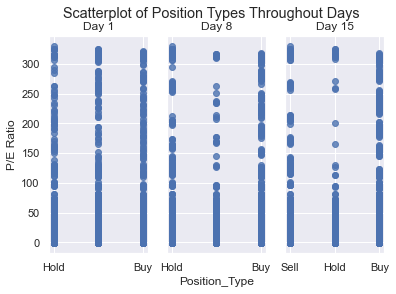

In [142]:
df = df_new

d = {'Position_Type':['Sell', 'Hold', 'Buy']}
vis2 = pd.DataFrame(d)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True)
fig.suptitle('Scatterplot of Position Types Throughout Days')
# plt.xticks(np.arange(0, 3, 1), labels=['a','b','c'])

plt.xticks(np.arange(0, 3, 1))

vis21_sns = sns.regplot(ax=ax1, data=df,  x="day_1", y="P/E (LTM)", fit_reg=False)


vis21_sns.set_xticklabels(vis2['Position_Type'], rotation='horizontal', fontsize=11)
vis21_sns.set(xlabel='', ylabel='P/E Ratio')
ax1.set_title('Day 1')



vis22_sns = sns.regplot(ax=ax2, data=df,  x="day_8", y="P/E (LTM)", fit_reg=False)
# plt.xticks(np.arange(0, 5, 1))
vis22_sns.set_xticklabels(vis2['Position_Type'], rotation='horizontal', fontsize=11)
vis22_sns.set(xlabel='Position_Type', ylabel=' ')
ax2.set_title('Day 8')


vis23_sns = sns.regplot(ax=ax3, data=df,  x="day_15", y="P/E (LTM)", fit_reg=False)
# plt.xticks(np.arange(0, 3, 1))
vis23_sns.set_xticklabels(vis2['Position_Type'], rotation='horizontal', fontsize=11)
vis23_sns.set(xlabel='', ylabel=' ')
ax3.set_title('Day 15')



# Move the legend to an empty part of the plot


(Please note that the labels should be in order Sell, Hold, Buy- from right to the left)

## Running the original models

This section applies some of the original models from Matloob and Khushi (2021) to our data. In particular we apply Random Forest, KNNeighbors, a Multi Layered Perceptron and Logistic Regression Classifiers. We then store the classification scores (on test data) and compare them to each other.

In [7]:
# Defining the function to acuumulate original models scores
# (Partly based on the code from Matloob and Khushi (2021))
(https://github.com/sjdee/Research-Stock-Prediction)

def accumulate_data(report_data,report,accuracy,day_name,model_name,minify_data,f1_scores):
  
  print(day_name)
  print(report)
  
  if(minify_data == True):

    row = {}
    row['day'] = day_name.replace("day_", "") 
    row['accuracy'] = accuracy
    row['f1_weigthed'] = f1_scores[0]
    row['model'] = model_name

    # unravel report for the given day       
    lines = report.split('\n')
    for line in lines[2:-5]:

      row_data = line.split('     ')

      # update recall for sell
      if(float(row_data[1])==0.0):
        row['sell_recall']= float(row_data[3])
      # update precison for buy
      if(float(row_data[1])==2.0):
        row['buy_precison']= float(row_data[2])

    report_data.append(row)


  else:    
    print('This is not to be used')

  return report_data

In [8]:
#Defining the function to run a classifier for all 15 labels (days)
# (Based on the code from Matloob and Khushi (2021))
def run_classifier (pDf, m, params, model_name, minify_data, less_columns, print_data):  

  
  df = pDf
  
  df.dropna(inplace=True)
  features = df.iloc[:,1:23]
  labels = df.iloc[:,23:]
    
  report_data = []


  for i in range(len(labels.columns)):
    # specify the feature set, target set, the test size and random_state to select records randomly
    X_train, X_test, y_train, y_test = train_test_split(features, labels.iloc[:,i], test_size=0.3,random_state=0) 

    # Scaling values in the feature set
    scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    X_train = scaling.transform(X_train)
    X_test = scaling.transform(X_test)


    # Create a decision tree Classifier
    clf = m().set_params(**params)

    # Train the model using the training sets
    clf.fit(X_train, y_train)

    # Predict the response for test dataset
    y_pred = clf.predict(X_test)


    accuracy = metrics.accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    f1_scores =[] 
    f1_scores.insert(2, metrics.f1_score(y_test, y_pred, average='weighted'))

    accumulate_data(report_data,report,accuracy,labels.columns[i], model_name, minify_data,f1_scores)


    
  return report_data

In [12]:
dataframe

,day,accuracy,f1_weigthed,model,sell_recall,buy_precison
0,1,0.566435,0.531608,Decision Tree,0.21,0.31
1,2,0.518469,0.511131,Decision Tree,0.38,0.48
2,3,0.547592,0.546958,Decision Tree,0.49,0.57
3,4,0.564806,0.565081,Decision Tree,0.54,0.61
4,5,0.563089,0.562792,Decision Tree,0.56,0.63
5,6,0.589284,0.587561,Decision Tree,0.61,0.67
6,7,0.617086,0.612837,Decision Tree,0.65,0.69
7,8,0.654134,0.649125,Decision Tree,0.69,0.73
8,9,0.670556,0.662363,Decision Tree,0.71,0.74
9,10,0.691578,0.682342,Decision Tree,0.74,0.75


In [13]:
#Running all classifiers and storing the results
less_columns = False
minify = True
print_data = False

models = [
            RandomForestClassifier,
            KNeighborsClassifier,
            DecisionTreeClassifier,
            MLPClassifier,
            LogisticRegression
        ]

model_names = ['RF', 'KNN', 'DTree', 'MLP', 'LReg']

params = [{
    'random_state': 42,
    'n_jobs': -1, 
    'n_estimators': 10
    },
    {'weights' : 'uniform',
    'n_neighbors' : 5,
    'n_jobs': -1
    },
    {'random_state': 42,
    'criterion' : 'gini', 
    'max_depth' : 3, 
    'min_samples_leaf' : 5
    },
    {'random_state': 42,
    'solver' : 'lbfgs', 
    'alpha' : 1e-5, 
    'hidden_layer_sizes' : (5, 2), 
    'random_state' : 0
    },
    {
    'random_state' : 42,
    'penalty' : 'l2',
    'C' : 0.8,
    'n_jobs': -1
    }]

reports = {}
counter = 0

for m in models:
    report = run_classifier(df_new, m, params[counter], model_names[counter],  minify, less_columns, print_data)
    dataframe = pd.DataFrame.from_dict(report)
    reports[model_names[counter]] = dataframe
    print("\n Completed fitting", model_names[counter], '\n')
    counter += 1

day_1
              precision    recall  f1-score   support

         0.0       0.28      0.21      0.24      8224
         1.0       0.66      0.81      0.73     27560
         2.0       0.31      0.18      0.22      9644

    accuracy                           0.57     45428
   macro avg       0.42      0.40      0.40     45428
weighted avg       0.52      0.57      0.53     45428

day_2
              precision    recall  f1-score   support

         0.0       0.42      0.38      0.40     10838
         1.0       0.57      0.67      0.62     21014
         2.0       0.48      0.40      0.44     13576

    accuracy                           0.52     45428
   macro avg       0.49      0.48      0.48     45428
weighted avg       0.51      0.52      0.51     45428

day_3
              precision    recall  f1-score   support

         0.0       0.50      0.49      0.50     12116
         1.0       0.55      0.60      0.58     17512
         2.0       0.57      0.53      0.55     15800

  

In [169]:

reports['RF']

,day,accuracy,f1_weigthed,model,sell_recall,buy_precison
0,1,0.566435,0.531608,RF,0.21,0.31
1,2,0.518469,0.511131,RF,0.38,0.48
2,3,0.547592,0.546958,RF,0.49,0.57
3,4,0.564806,0.565081,RF,0.54,0.61
4,5,0.563089,0.562792,RF,0.56,0.63
5,6,0.589284,0.587561,RF,0.61,0.67
6,7,0.617086,0.612837,RF,0.65,0.69
7,8,0.654134,0.649125,RF,0.69,0.73
8,9,0.670556,0.662363,RF,0.71,0.74
9,10,0.691578,0.682342,RF,0.74,0.75


In [170]:
reports['KNN']

,day,accuracy,f1_weigthed,model,sell_recall,buy_precison
0,1,0.558884,0.518031,KNN,0.24,0.28
1,2,0.469974,0.458219,KNN,0.38,0.43
2,3,0.470063,0.468397,KNN,0.48,0.51
3,4,0.487167,0.487791,KNN,0.53,0.55
4,5,0.511271,0.511738,KNN,0.57,0.60
5,6,0.533680,0.532937,KNN,0.60,0.63
6,7,0.554416,0.551560,KNN,0.63,0.65
7,8,0.574205,0.571160,KNN,0.63,0.67
8,9,0.594941,0.589509,KNN,0.67,0.69
9,10,0.610835,0.604609,KNN,0.68,0.71


In [171]:
reports['DTree']

,day,accuracy,f1_weigthed,model,sell_recall,buy_precison
0,1,0.609184,0.497970,DTree,0.00,0.36
1,2,0.474509,0.415255,DTree,0.00,0.37
2,3,0.450229,0.382792,DTree,0.00,0.40
3,4,0.438342,0.363150,DTree,0.00,0.43
4,5,0.433037,0.354511,DTree,0.00,0.44
5,6,0.442502,0.331680,DTree,0.00,0.45
6,7,0.450295,0.322372,DTree,0.00,0.45
7,8,0.456811,0.286483,DTree,0.00,0.46
8,9,0.466915,0.297235,DTree,0.00,0.47
9,10,0.476512,0.307568,DTree,0.00,0.48


In [172]:
reports['MLP']

,day,accuracy,f1_weigthed,model,sell_recall,buy_precison
0,1,0.606674,0.458156,MLP,0.0,0.00
1,2,0.489456,0.429397,MLP,0.0,0.38
2,3,0.482500,0.410603,MLP,0.0,0.43
3,4,0.382693,0.211839,MLP,0.0,0.38
4,5,0.407832,0.236288,MLP,0.0,0.41
5,6,0.429911,0.258511,MLP,0.0,0.43
6,7,0.443757,0.272789,MLP,0.0,0.44
7,8,0.456811,0.286483,MLP,0.0,0.46
8,9,0.466915,0.297235,MLP,0.0,0.47
9,10,0.476512,0.307568,MLP,0.0,0.48


In [ ]:
reports['LReg']

,day,accuracy,f1_weigthed,model,sell_recall,buy_precison
0,1,0.606454,0.481691,LReg,0.01,0.35
1,2,0.484327,0.378652,LReg,0.01,0.41
2,3,0.453267,0.375862,LReg,0.01,0.44
3,4,0.445738,0.371359,LReg,0.01,0.43
4,5,0.424474,0.324250,LReg,0.02,0.42
5,6,0.431958,0.292732,LReg,0.01,0.43
6,7,0.443361,0.285587,LReg,0.01,0.45
7,8,0.455600,0.293561,LReg,0.01,0.46
8,9,0.465880,0.301569,LReg,0.01,0.47
9,10,0.476006,0.311885,LReg,0.00,0.48


Looking at the results, we can see that two models stand out form the rest: Random Forests and KNNeighbors, with F1 Weighted scores for the 15th day of 0.75 and 0.66, and accuracy of 76 and 67 respectively. This is a significant improvement from 0.33 if the classes were to be randomly guessed. We also see a clear trend: the scores improve with the number of days. Hence, for purposes of this paper we decided to fine-tune the best two models only on the 15th day labels, since this is where we are most likely to get the best result.

## Fine Tuning

In [ ]:
#Pipeline with gridsearch
def run_classifiers_gs(DF, model_list, model_names, grids):
    
    df = DF

    #Dropping N/As and selecting fatures/labels
    df.dropna(inplace=True)
    features = df.iloc[:,1:23]
    labels = df.iloc[:,23:]

    #Storage for test set scores, confusion matrices and best models
    results = pd.DataFrame(index=list(range(0, (len(models)))), columns=['Model Name', 'Accuracy', 'F1 Weighted',
    'Sell Recall', 'Buy Precison'])
    report_data = {}
    best_models = {}

    counter = 0


    for m in model_list:

        # specify the feature set, target set, the test size and random_state to select records randomly
        X_train, X_test, y_train, y_test = train_test_split(features, labels.iloc[:,14], test_size=0.3,random_state=42) 

        # Scaling values in the feature set
        scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
        X_train = scaling.transform(X_train)
        X_test = scaling.transform(X_test)

        #Use the grid corresponfing to the classifier
        random_gridcv = grids[counter]

        clf = RandomizedSearchCV(m(), random_gridcv, cv = 10, scoring= 'f1_weighted')
        clf = clf.fit(X_train, y_train)

        #Output best accuracy and parameters found with the gridseacrh
        print(f'Best training f1 weighted score is {np.abs(clf.best_score_)}')
        print(f'Best set of parameters is  {clf.best_params_}')

        #Fitting and storing the best models
        params = clf.best_params_
        best = m().set_params(**params)
        best = best.fit(X_train, y_train)
        best_models[model_names[counter]] = best

        #Predicting y using the best model and X_test
        y_pred = best.predict(X_test)

        #Calculating and storing test scores
        accuracy = metrics.accuracy_score(y_test, y_pred)
        f1_w = metrics.f1_score(y_test, y_pred, average='weighted')


        # f1_scores =[] 
        # f1_scores.insert(2, metrics.f1_score(y_test, y_pred, average='weighted'))
        report = classification_report(y_test, y_pred)
        # unravel report for the given day       
        lines = report.split('\n')
        for line in lines[2:-5]:

            row_data = line.split('     ')

            # update recall for sell
            if(float(row_data[1])==0.0):
                results.loc[counter, 'Sell Recall']= float(row_data[3])
            # update precison for buy
            if(float(row_data[1])==2.0):
                results.loc[counter, 'Buy Precison']= float(row_data[2])


        results.loc[counter, 'Model Name'] = model_names[counter]
        results.loc[counter, 'Accuracy'] = accuracy
        results.loc[counter, 'F1 Weighted'] = f1_w
        
        #Calculating and storing confusion matrices
        report = classification_report(y_test, y_pred)
        report_data[model_names[counter]] = report

        print("\n Completed fitting", model_names[counter], '\n')

        counter += 1
    
    return results, report_data, best_models

In [ ]:
RF = RandomForestClassifier
KNN = KNeighborsClassifier

models = [RF, KNN]
model_names = ['RF', 'KNN']


grids = [{
 'random_state': [42],
 'n_jobs':[-1],
 'n_estimators': [5,10,20,40,50],
 'criterion' : ['gini','entropy']
 },
 {
 'n_neighbors': [3,4,5,6],
 'weights':['distance', 'uniform'],
 'n_jobs':[-1]
 }]

test_scores, confusion_mx, best_est_models = run_classifiers_gs(df_new, models, model_names, grids)

Best training f1 weighted score is 0.7792387480627171
Best set of parameters is  {'random_state': 42, 'n_jobs': -1, 'n_estimators': 50, 'criterion': 'gini'}

 Completed fitting RF 

Best training f1 weighted score is 0.6984272669440001
Best set of parameters is  {'weights': 'distance', 'n_neighbors': 3, 'n_jobs': -1}

 Completed fitting KNN 



In [ ]:
test_scores
best_est_models
print(confusion_mx['RF'])

,Model Name,Accuracy,F1 Weighted,Sell Recall,Buy Precison
0,RF,0.79713,0.784225,0.83,0.83
1,KNN,0.708132,0.704309,0.72,0.79


{'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42),
 'KNN': KNeighborsClassifier(n_jobs=-1, n_neighbors=3, weights='distance')}

              precision    recall  f1-score   support

         0.0       0.82      0.83      0.83     14674
         1.0       0.53      0.34      0.42      7299
         2.0       0.83      0.92      0.87     23455

    accuracy                           0.80     45428
   macro avg       0.73      0.70      0.70     45428
weighted avg       0.78      0.80      0.78     45428



## Voting Classifier

In [ ]:
#
df = df_new

#Dropping N/As and selecting fatures/labels
df.dropna(inplace=True)
features = df.iloc[:,1:23]
labels = df.iloc[:,23:]

X_train, X_test, y_train, y_test = train_test_split(features, labels.iloc[:,14], test_size=0.3,random_state=42)
scaling = MinMaxScaler(feature_range=(0,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)


vote = VotingClassifier(estimators=[
    ('RF', best_est_models['RF']),
    ('KNN', best_est_models['KNN'])],
    voting = 'hard',
    weights = [1,1]
        )

vote = vote.fit(X_train, y_train)

y_pred = vote.predict(X_test)
f1_weighted =  metrics.f1_score(y_test, y_pred, average='weighted')
f1_weighted

0.7514720384087623

Voting does not result in improvemnt. Hence the best classifier found is Random Forest with F1 score of 0.78.